## HousePrices Kaggle

## 分析流程

### 1.資料匯入
- 匯入套件 
- 讀取資料
### 2.資料確認
- 檢查有無遺失值，補入遺失值
- 資料檢視
- 有無離群值
### 3.變數工程
- 新增變數
- 調整連續行變數尺規
- 平滑預測變數
- 類別行變數調整為dummy variable
### 4.變數檢視
- 關聯性
- 挑選變數（偷懶沒做）
### 5.基礎建模
- xgboost
- gbm
- Elastic Net
- KRR
- lasso
- LR
### 6. Stacking Model
- ensemble averaged model
- Stacking model 1 2 3
### 7.產出預測結果


### 1.資料匯入
- 匯入套件

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import preprocessing

#小數點取到第三位
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 


### 1.資料匯入
- 讀取資料

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train.head()
#test.head()
train['flag'] ='train'
test['flag'] ='test'
fulldata = pd.concat((train, test)).reset_index(drop=True) 
#fulldata.head()
#看資料筆數
print(len(fulldata),len(train),len(test))

2919 1460 1459


In [3]:
#取出類別行變數與連續行變數
category_var = fulldata.select_dtypes(['object']).columns 
conti_var = fulldata.select_dtypes(exclude=['object']).columns 
#category_var
#conti_var
#檢查有無交集，空集合是對的
category_var.intersection(conti_var )

Index([], dtype='object')

### 資料確認
- 檢查遺失值

In [4]:
#concat(物件，axis=1 => 直的排，keys=物件源)
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
Alley,1369,1352.000,2919,2721.000,0.932
BsmtCond,37,45.000,2919,82.000,0.028
BsmtExposure,38,44.000,2919,82.000,0.028
BsmtFinSF1,0,1.000,2919,1.000,0.000
BsmtFinSF2,0,1.000,2919,1.000,0.000
BsmtFinType1,37,42.000,2919,79.000,0.027
BsmtFinType2,38,42.000,2919,80.000,0.027
BsmtFullBath,0,2.000,2919,2.000,0.001
BsmtHalfBath,0,2.000,2919,2.000,0.001
BsmtQual,37,44.000,2919,81.000,0.028


### 2.資料確認
- 補入遺失值

In [5]:
#取出類別型遺失值<5的欄位
m1 = NAs[(NAs['Missing sum']>0) & (NAs['Missing sum']<5)].index
for col in category_var.intersection(m1):
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna(fulldata[col].value_counts().keys()[0], inplace=True)
    print(col +'遺失值補' + fulldata[col].value_counts().keys()[0])

Electrical遺失值補SBrkr
Exterior1st遺失值補VinylSd
Exterior2nd遺失值補VinylSd
Functional遺失值補Typ
KitchenQual遺失值補TA
MSZoning遺失值補RL
SaleType遺失值補WD
Utilities遺失值補AllPub


In [6]:
#取出連續型遺失值<5的欄位
m2 = NAs[(NAs['Missing sum']>0) & (NAs['Missing sum']<5)].index
for col in conti_var.intersection(m2):
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna(0, inplace=True)
    print(col +'遺失值補' + '0')

BsmtFinSF1遺失值補0
BsmtFinSF2遺失值補0
BsmtFullBath遺失值補0
BsmtHalfBath遺失值補0
BsmtUnfSF遺失值補0
GarageArea遺失值補0
GarageCars遺失值補0
TotalBsmtSF遺失值補0


In [7]:
NAs = pd.concat([fulldata[fulldata['flag']=='train'].isnull().sum(), fulldata[fulldata['flag']=='test'].isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
Alley,1369,1352,2919,2721,0.932
BsmtCond,37,45,2919,82,0.028
BsmtExposure,38,44,2919,82,0.028
BsmtFinType1,37,42,2919,79,0.027
BsmtFinType2,38,42,2919,80,0.027
BsmtQual,37,44,2919,81,0.028
Fence,1179,1169,2919,2348,0.804
FireplaceQu,690,730,2919,1420,0.486
GarageCond,81,78,2919,159,0.054
GarageFinish,81,78,2919,159,0.054


- 補入遺失值
#### BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual
#### GarageCond GarageFinish GarageQual GarageType GarageYrBlt 
#### MasVnrArea MasVnrType 
#### Fence FireplaceQu PoolQC Alley MiscFeature

In [8]:
#挑出Bsm系列變數觀察遺失值狀況，發現BsmtCond為空，其他皆為空，判斷為皆無地下室，填寫None
b = fulldata[['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']]
#b[fulldata['BsmtCond'].isnull()]

In [9]:
for col in ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')

BsmtCond遺失值補None
BsmtExposure遺失值補None
BsmtFinType1遺失值補None
BsmtFinType2遺失值補None
BsmtQual遺失值補None


In [10]:
#挑出Garage系列變數觀察遺失值狀況，發現GarageCond為空，其他皆為空，判斷無車庫，填寫None
g = fulldata[['GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']]
#g[fulldata['GarageCond'].isnull()]

In [11]:
for col in ['GarageCond','GarageFinish','GarageQual','GarageType']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')

fulldata['GarageYrBlt'].fillna(0, inplace=True)

GarageCond遺失值補None
GarageFinish遺失值補None
GarageQual遺失值補None
GarageType遺失值補None


In [12]:
#MasVnrArea=0 則 MasVnrType為NA
m = fulldata[['MasVnrArea','MasVnrType']]
#m[fulldata['MasVnrArea'].isnull()]
fulldata['MasVnrType'].fillna('None', inplace=True)
fulldata['MasVnrArea'].fillna(0, inplace=True)

In [13]:
# Fence FireplaceQu PoolQC Alley PoolQC為空判斷為無此項設施
for col in ['Fence', 'FireplaceQu', 'PoolQC' ,'Alley' ,'MiscFeature']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')
    

Fence遺失值補None
FireplaceQu遺失值補None
PoolQC遺失值補None
Alley遺失值補None
MiscFeature遺失值補None


- 補入遺失值
#### LotFrontage 用隨機森林補值

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

def imputeMissing(df, idx, predictors):
    tempdf = df[df[outcome].isnull()].index
    tempndf = df[df[idx].notnull()].index
    model = RandomForestRegressor(n_estimators=100) 
    model.fit(df.loc[tempndf, predictors], df.loc[tempndf, [outcome]]) 
    predict = model.predict(df.loc[tempndf, predictors])
    j=0;
    for i in tempdf:
        df.loc[i,outcome] = predict[j]
        j=j+1 
    return(df)

predictors=['LotArea','Street','LotShape','LandContour','LotConfig']
outcome='LotFrontage'

var_mod = ['Street','LotShape','LandContour','LotConfig']

le = LabelEncoder()
for i in var_mod:
    fulldata[i] = le.fit_transform(fulldata[i].astype(str))
fulldata[var_mod].head(5)

/Users/YiHsien/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,Street,LotShape,LandContour,LotConfig
0,1,3,3,4
1,1,3,3,2
2,1,0,3,4
3,1,0,3,0
4,1,0,3,2


In [15]:
#使用隨機森林預測遺失值
predictors=['LotArea','Street','LotShape','LandContour','LotConfig'] 
outcome='LotFrontage'
var_mod = ['Street','LotShape','LandContour','LotConfig'] 
le = LabelEncoder()

for i in var_mod:
    fulldata[i] = le.fit_transform(fulldata[i].astype(str))
    fulldata = imputeMissing(fulldata,outcome,predictors) 

fulldata['LotFrontage'].isnull().sum()


/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0

#### 確認是否已完成遺失值補值

In [16]:
NAs = pd.concat([fulldata[fulldata['flag']=='train'].isnull().sum(), fulldata[fulldata['flag']=='test'].isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
SalePrice,0,1459,2919,1459,0.500


## 2.資料確認
- 資料檢視

### 資料觀察 MSSubClass YrSold MoSold YearBuilt GarageYrBlt

In [17]:
import pandas as pd
pd.set_option('display.max_columns',200)
fulldata[conti_var].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,1460.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000
mean,1159.582,336.484,2.602,2.860,441.272,49.565,0.430,0.061,560.580,23.098,0.597,1.568,472.713,1.766,1870.364,1500.760,0.380,1460.000,1.045,10168.114,69.506,4.694,57.138,101.396,50.826,6.213,47.487,5.565,6.089,2.252,180921.196,16.062,6.452,1051.417,93.710,1971.313,1984.264,2007.793
std,392.362,428.701,25.188,0.823,455.606,169.179,0.525,0.246,439.591,64.244,0.646,0.553,215.536,0.762,449.686,506.051,0.503,842.787,0.214,7886.996,22.851,46.397,42.518,178.855,567.402,2.715,67.575,1.113,1.410,35.664,79442.503,56.184,1.569,441.120,126.527,30.291,20.894,1.315
min,334.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,1.000,0.000,1300.000,21.000,0.000,20.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,34900.000,0.000,2.000,0.000,0.000,1872.000,1950.000,2006.000
25%,876.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,220.000,0.000,0.000,1.000,320.000,1.000,1957.000,1126.000,0.000,730.500,1.000,7478.000,59.000,0.000,20.000,0.000,0.000,4.000,0.000,5.000,5.000,0.000,129975.000,0.000,5.000,793.000,0.000,1953.500,1965.000,2007.000
50%,1082.000,0.000,0.000,3.000,368.000,0.000,0.000,0.000,467.000,0.000,1.000,2.000,480.000,2.000,1977.000,1444.000,0.000,1460.000,1.000,9453.000,68.480,0.000,50.000,0.000,0.000,6.000,26.000,5.000,6.000,0.000,163000.000,0.000,6.000,989.000,0.000,1973.000,1993.000,2008.000
75%,1387.500,704.000,0.000,3.000,733.000,0.000,1.000,0.000,805.000,0.000,1.000,2.000,576.000,2.000,2001.000,1743.500,1.000,2189.500,1.000,11570.000,80.000,0.000,70.000,163.500,0.000,8.000,70.000,6.000,7.000,0.000,214000.000,0.000,7.000,1302.000,168.000,2001.000,2004.000,2009.000
max,5095.000,2065.000,508.000,8.000,5644.000,1526.000,3.000,2.000,2336.000,1012.000,4.000,4.000,1488.000,5.000,2207.000,5642.000,2.000,2919.000,3.000,215245.000,313.000,1064.000,190.000,1600.000,17000.000,12.000,742.000,9.000,10.000,800.000,755000.000,576.000,15.000,6110.000,1424.000,2010.000,2010.000,2010.000


In [18]:
print(fulldata['GarageYrBlt'].describe())
fulldata[fulldata['GarageYrBlt']>2100]
fulldata.loc[2592, 'GarageYrBlt'] = 2007

count   2919.000
mean    1870.364
std      449.686
min        0.000
25%     1957.000
50%     1977.000
75%     2001.000
max     2207.000
Name: GarageYrBlt, dtype: float64


In [19]:
# MSSubClass YrSold MoSold YearBuilt 為類別型資料
#MSSubClass
fulldata['MSSubClass'] = fulldata['MSSubClass'].apply(str)

#Year month
fulldata['YrSold_char'] = fulldata['YrSold'].astype(str)
fulldata['MoSold_char'] = fulldata['MoSold'].astype(str)
fulldata['YearBuilt_char'] = fulldata['YearBuilt'].astype(str)

### 檢查類別行資料分布

In [20]:
char = fulldata[category_var].apply(lambda x: len(np.unique(x)))
char.sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
HouseStyle        8
Condition2        8
RoofMatl          8
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
GarageCond        6
Heating           6
SaleCondition     6
RoofStyle         6
FireplaceQu       6
Foundation        6
GarageQual        6
HeatingQC         5
BsmtQual          5
BldgType          5
LotConfig         5
Electrical        5
ExterCond         5
BsmtExposure      5
Fence             5
BsmtCond          5
MiscFeature       5
MSZoning          5
LandContour       4
KitchenQual       4
PoolQC            4
ExterQual         4
LotShape          4
GarageFinish      4
MasVnrType        4
Alley             3
LandSlope         3
PavedDrive        3
CentralAir        2
Utilities         2
Street            2
flag              2
dtype: int64

In [21]:
# Utilities CentralAir 類別較少，進行確認，Utilities皆為同一值對分析無幫助，故刪除
print(fulldata['Utilities'].value_counts())
print(fulldata['CentralAir'].value_counts()) 
fulldata = fulldata.drop('Utilities', axis=1)

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
Y    2723
N     196
Name: CentralAir, dtype: int64


### 2.資料確認
- 移除離群值

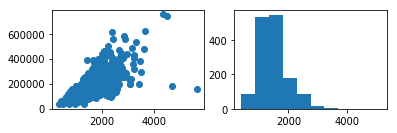

In [22]:
#確認 GrLivArea房價過低，測試集也無GrLivArea 4500之資料，故刪除
plt.subplot(221)
plt.scatter(train.GrLivArea, train.SalePrice)
plt.subplot(222)
plt.hist(test.GrLivArea)
plt.show()

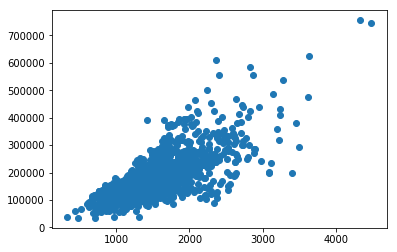

In [23]:
fulldata = fulldata[((fulldata.GrLivArea < 4500) & (fulldata.flag=="train"))| ((fulldata.flag=="test"))]
plt.scatter(fulldata.GrLivArea, fulldata.SalePrice)

### 3.變數工程
- 創造新變數

In [24]:
#房子蓋好後多久售出
fulldata['yeardiff'] = fulldata['YrSold'] - fulldata['YearBuilt']
#房子蓋好後多久裝潢
fulldata['yeardiffremod'] = fulldata['YearRemodAdd'] - fulldata['YearBuilt']
#裝潢後多久售出
fulldata['yearremoddiff'] = fulldata['YrSold'] - fulldata['YearRemodAdd']

#總面積
fulldata['allarea'] = (fulldata['LotArea'] + fulldata['MasVnrArea'] + fulldata['BsmtFinSF1'] + 
                      fulldata['BsmtFinSF2'] + fulldata['BsmtUnfSF'] + fulldata['TotalBsmtSF'] + 
                      fulldata['1stFlrSF'] + fulldata['2ndFlrSF'] + fulldata['LowQualFinSF'] + 
                      fulldata['GrLivArea'] + fulldata['GarageArea'] + fulldata['WoodDeckSF'] + 
                      fulldata['OpenPorchSF'] + fulldata['EnclosedPorch'] + fulldata['3SsnPorch'] + 
                      fulldata['ScreenPorch'] +fulldata['PoolArea'])
#主要面積
fulldata['mainarea'] = fulldata['TotalBsmtSF'] +fulldata['1stFlrSF'] + fulldata['2ndFlrSF']
#其他面積
fulldata['elsearea'] = fulldata['allarea'] - fulldata['mainarea'] 

#計算品質次數 Ex>Gd>TA>Fa>Po>None 5=>4=>3=>2=>1
qual = fulldata[['HeatingQC','KitchenQual','FireplaceQu','GarageQual','PoolQC','ExterQual','BsmtQual']]

for col in ['HeatingQC','KitchenQual','FireplaceQu','GarageQual','PoolQC','ExterQual','BsmtQual']:
    print(col)
    conditions = [
        (qual[col] == 'Ex'),
        (qual[col] == 'Gd'),
        (qual[col] == 'TA'),
        (qual[col] == 'Fa'),
        (qual[col] == 'Po'),
        (qual[col] == 'None')
    ]
    choices = [5,4,3,2,1,0]
    qual[col] = np.select(conditions, choices,default=999)

fulldata['qc_score'] = qual.sum(axis = 1)

HeatingQC
KitchenQual
FireplaceQu
GarageQual
PoolQC


/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ExterQual
BsmtQual


### 3.變數工程 
- 平滑預測變數：房價取log

/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


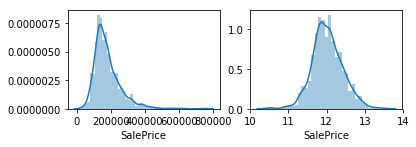

In [25]:
plt.subplot(221)
ax = sns.distplot(train['SalePrice'])
plt.subplot(222)
ax = sns.distplot(np.log(train['SalePrice']))

In [26]:
fulldata['SalePrice'] = np.log(fulldata['SalePrice'])

### 3.變數工程 
- 調整連續行變數尺規

In [27]:

#重新取出類別行變數與連續行變數
category_var = fulldata.select_dtypes(['object']).columns 
conti_var = fulldata.select_dtypes(exclude=['object']).columns
conti_var = [col for col in conti_var if col != 'SalePrice']
conti_var = [col for col in conti_var if col != 'Id']
conti_var

# Check the skew of all numerical features
skewed_feats = fulldata[conti_var].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
elsearea,11.674
3SsnPorch,11.372
allarea,10.595
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002


In [28]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
skew_index = skewness.index

for col in skew_index:
    fulldata[col]= boxcox1p(fulldata[col], 0.3)
     
skew_features2 = fulldata[conti_var].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

There are 46 skewed numerical features to Box Cox transform


,skew
PoolArea,15.971
3SsnPorch,9.086
LowQualFinSF,9.031
MiscVal,6.609
KitchenAbvGr,3.847
BsmtHalfBath,3.803
ScreenPorch,3.034
BsmtFinSF2,2.723
EnclosedPorch,2.127
allarea,1.582


### 3.變數工程 
- 類別行變數改為dummy variable

In [29]:
fulldata = fulldata.drop('Id', axis=1)
fulldata.shape

(2917, 90)

In [30]:
base = pd.get_dummies(fulldata)
base.shape

(2917, 448)

### 4.變數檢視

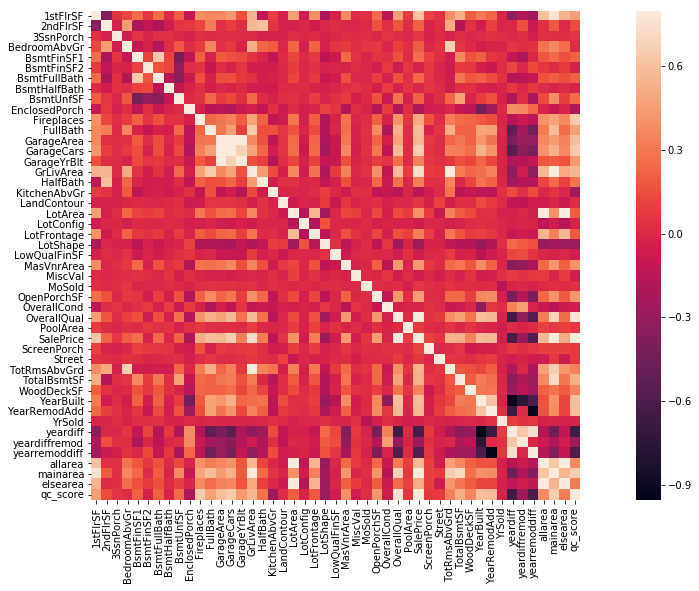

In [31]:
corrmat = fulldata.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

## 5.建模

In [33]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
#import lightgbm as lgb


## cross validation

In [86]:
skipedCols = ['SalePrice','Id','yearremoddiff']
predictors = [x for x in base.columns if x not in skipedCols]

#Validation function
n_folds = 5
new_train = base[:1458]
new_test = base[1458:]
y_train = new_train.SalePrice

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(new_train[predictors].values)
    rmse= np.sqrt(-cross_val_score(model, new_train[predictors].values, y_train , scoring="neg_mean_squared_error", cv = kf))
    return(rmse)



## XGB

In [87]:
#Various hyper-parameters to tune
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [4],
              'min_child_weight': [2],
              'subsample': [0.9],
              'colsample_bytree': [0.9],
              'n_estimators': [2000]
              }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(new_train[predictors].values,new_train.SalePrice.values)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:   23.3s finished


0.9040582008638408
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 2000, 'nthread': -1, 'objective': 'reg:linear', 'subsample': 0.9}


In [88]:
#model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                             learning_rate=0.05, max_depth=3, 
#                             min_child_weight=1.7817, n_estimators=2200,
#                             reg_alpha=0.4640, reg_lambda=0.8571,
#                             subsample=0.5213, silent=1,
#                             random_state =7, nthread = -1)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.9,
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=2, n_estimators=2000,
                             subsample=0.9, silent=1,
                            nthread = -1,objective='reg:linear'
                            )

In [89]:
model_xgb.fit(new_train[predictors].values,new_train.SalePrice.values)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1162 (0.0071)



In [90]:
score

array([0.11355462, 0.12120984, 0.12705165, 0.10677828, 0.11225361])

## GBM 

In [91]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [92]:
GBoost.fit(new_train[predictors].values,new_train.SalePrice.values)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1185 (0.0048)



## Elastic Net (L1 and L2 penalty)

In [93]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=5, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(new_train[predictors].values,new_train.SalePrice.values)
print(elastic_model3.steps[1][1].l1_ratio_)
print(elastic_model3.steps[1][1].alpha_)

1.0
0.0006


In [142]:

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0006, l1_ratio=1,max_iter=3000))
ENet.fit(new_train[predictors].values,new_train.SalePrice.values)

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1102 (0.0058)



## KRR 

In [95]:

kr = GridSearchCV(KernelRidge(kernel='polynomial'), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5),
                              "degree":[1,2,3,4,5],
                              "coef0":[1,2,3]})

kr.fit(new_train[predictors].values,new_train.SalePrice.values)
print(kr.best_params_)

{'alpha': 1.0, 'coef0': 1, 'degree': 1, 'gamma': 0.1}


In [96]:
KRR = KernelRidge(alpha=1, kernel='polynomial', degree=1, coef0=1, gamma = 0.1)

In [97]:
KRR.fit(new_train[predictors].values,new_train.SalePrice.values)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1143 (0.0069)



## lasso

In [124]:
lasso = GridSearchCV(Lasso(), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3,1e-4],"max_iter":[10000]})

lasso.fit(new_train[predictors].values,new_train.SalePrice.values)
print(lasso.best_params_)

{'alpha': 0.001, 'max_iter': 10000}


In [141]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.001,max_iter=10000))
lasso.fit(new_train[predictors].values,new_train.SalePrice.values)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [100]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1113 (0.0058)



## LR

In [101]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
score = rmsle_cv(LR)
print("\nLR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




LR score: 59094933.3998 (118187890.3456)



## Ensemble 

In [102]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [129]:
averaged_models = AveragingModels(models = (model_xgb, GBoost, KRR, lasso,ENet))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1086 (0.0060)



In [130]:
score

array([0.10464954, 0.11058495, 0.11879678, 0.10113248, 0.10779238])

In [131]:
averaged_models.fit(new_train[predictors].values,new_train.SalePrice.values)

AveragingModels(models=(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=2000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
      ...se, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])))

## Stacking Model

In [143]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models


krr = make_pipeline(RobustScaler(),
                    KernelRidge(alpha=1, kernel='polynomial', degree=1, coef0=1, gamma = 0.1)
                    )


lasso = make_pipeline(RobustScaler(),
                      Lasso( alpha = 0.001,max_iter=10000)
                      )

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNet(alpha=0.0006, l1_ratio=1,max_iter=3000)
                          )

gbm = make_pipeline(RobustScaler(),
                    GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
                   )

xgboost = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(colsample_bytree=0.9,
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=2, n_estimators=2000,
                             subsample=0.9, silent=1,
                            nthread = -1,objective='reg:linear')
                       )

#stack
stack_gen1 = StackingCVRegressor(regressors=(krr,elasticnet,xgboost), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

stack_gen2 = StackingCVRegressor(regressors=(lasso,krr,gbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)


stack_gen3 = StackingCVRegressor(regressors=(stack_gen1,stack_gen2,averaged_models), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

#prepare dataframes
#stackX = np.array(new_train[predictors].values)
#stacky = np.array(new_train.SalePrice.values)

In [144]:
import time
import datetime
print("cross validated scores")

for model, label in zip([stack_gen1,stack_gen2,stack_gen3],
                     ['stack1','stack2','stack3']):
    t0 = datetime.datetime.now()
    model.fit(new_train[predictors].values, new_train.SalePrice.values)
    SG_scores = cross_val_score(model, new_train[predictors].values, new_train.SalePrice.values, cv=5,
                               scoring='neg_mean_squared_error')
    fit_time = datetime.datetime.now() - t0
    print("RMSE", np.sqrt(-SG_scores.mean()), "SD", SG_scores.std(), label, "take {0}".format(fit_time))


cross validated scores
RMSE 0.11488540202056924 SD 0.0019724796261087903 stack1 take 0:21:41.537695
RMSE 0.11537941328441205 SD 0.0016583695892439798 stack2 take 0:09:17.789299
RMSE 0.11762448025842866 SD 0.0020784199464904045 stack3 take 3:04:25.182354


## output 

In [137]:
import math
stack_gen3_preds = np.expm1(stack_gen3.predict(new_test[predictors].values))
averaged_models_preds = np.expm1(averaged_models.predict(new_test[predictors].values))
elasticnet = np.expm1(ENet.predict(new_test[predictors].values))
ensemble = stack_gen3_preds*0.6 + averaged_models_preds*0.3 + elasticnet*0.1
ensemble_round = [ round(n/100,0)*100 for n in ensemble ]

In [136]:
#ensemble[0],round(ensemble[0]/100,0)*100

(123379.82052063412, 123400.0)

In [138]:
models = [stack_gen3_preds,averaged_models_preds,elasticnet,ensemble,ensemble_round]
model_name = ['stack_gen3','averaged','elasticnet','ensemble','ensemble_round']
for m,name in zip(models,model_name):
    sub = pd.DataFrame()
    sub['Id'] = test['Id']
    sub['SalePrice'] = m
    sub.to_csv("{0}.csv".format(name),index=False)


